# Get Data using Reddit's API

In [19]:
from dotenv import load_dotenv
from os import getenv
import requests
import json
import praw
from datetime import datetime
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
import googletrans
from googletrans import *
from sklearn.metrics import accuracy_score, classification_report

In [2]:
load_dotenv()

True

In [3]:
reddit = praw.Reddit(
    client_id=getenv("APP_ID"), # Right below 'personal use script'
    client_secret=getenv("APP_SECRET"), # secret
    user_agent=f"pda-2023 u/{getenv('USERNAME')}", # app-name u/username
    password=getenv('REDDIT_PASSWORD')
)
print(reddit.read_only)

True


## Storage as json

In [4]:
def comment_transport_json(subreddit,topic,post,comment):
    
    #json method

    # Selecting number of posts 
    subreddit = reddit.subreddit(subreddit)
    search = subreddit.search(topic, limit=post)
    limit=comment

    #Create dictionary    
    postDict = {}

    #Select post & comments
    for submission in search:
        postDict[submission.title] = []
        for comment in submission.comments.list()[:limit]:
            postDict[submission.title].append({
                'Comment':comment.body,
                'Date': str(datetime.utcfromtimestamp(comment.created_utc))
            })

    #Convert data in json format
    data=json.dumps(postDict)

    #Save data in a json file
    with open(f"{subreddit}_{topic}_Comments.json",'w') as f:
        f.write(data)
    
    print(f"\n {subreddit}_{topic}_comments.json file created! \n")

In [5]:
comment_transport_json('Monterrey','transmetro',20,10)


 Monterrey_transmetro_comments.json file created! 



## Storage as csv 

In [6]:
def comments_transport_csv(subreddit,topic,post,comments):
    # Selecting number of posts
    subreddit = reddit.subreddit(subreddit)
    search = subreddit.search(topic, limit=post)

    #Create an empty df 
    df_comm=pd.DataFrame(columns=["Post", "Comment", "Date"])

    # Getting comments for every post
    for submission in search:

        for comment in submission.comments.list()[:comments]:
            df_comm = df_comm.append({"Post":submission.title,"Comment": comment.body,"Date":datetime.utcfromtimestamp(comment.created_utc)}, ignore_index=True)

    # Detect language and translate comments to english
    translator = googletrans.Translator()
    if detect(df_comm['Comment'][0]) != 'en':
        #df_comm['Original_comment']=df_comm['Comment']
        df_comm['Comment'] = df_comm['Comment'].astype(str) #changing datatype to string 
        df_comm['Comment'] = df_comm['Comment'].apply(translator.translate, src='auto', dest='en').apply(getattr, args=('text',)) 

    df_comm['Sentiment_Value'] = df_comm['Comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_comm['Sentiment'] = df_comm['Sentiment_Value'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
    
    df_comm.to_csv(f"{subreddit}_{topic}_comments.csv",index=False)
    print(f"\n {subreddit}_{topic}_comments.csv file created! \n")
    return df_comm.head()


In [7]:
# Input the subreddit, topic for the search, number of posts and number of comments for every post
comments_transport_csv('france','metro',10,15)


 france_metro_comments.csv file created! 



,Post,Comment,Date,Sentiment_Value,Sentiment
0,Le METRO BOULOT DODO a t'il ses limites ?,"Welcome to the mid-30s crisis, more and more o...",2023-11-03 10:35:13,0.177288,Positive
1,Le METRO BOULOT DODO a t'il ses limites ?,"There are many, very many of us. Good luck.",2023-11-03 10:35:35,0.616667,Positive
2,Le METRO BOULOT DODO a t'il ses limites ?,You can also do something else.\nI have experi...,2023-11-03 11:11:34,0.005147,Positive
3,Le METRO BOULOT DODO a t'il ses limites ?,"Just curious, but what exactly are you doing i...",2023-11-03 14:57:13,0.050000,Positive
4,Le METRO BOULOT DODO a t'il ses limites ?,">I'm in finance.\n>\n>Today, I was hired in a ...",2023-11-03 18:08:04,-0.099107,Negative


In [8]:
comments_transport_csv('Monterrey','transmetro',10,15)


 Monterrey_transmetro_comments.csv file created! 



,Post,Comment,Date,Sentiment_Value,Sentiment
0,Transmetro: Sendero,What route are you talking about?,2023-12-15 11:48:17,0.000000,Neutral
1,Transmetro: Sendero,I understand the green ones are with the metro...,2023-12-15 20:57:26,-0.200000,Negative
2,Esto acaba de pasar en el transmetro de No ree...,Damn sick people...\n\nFortunately you are fine,2021-10-18 13:38:33,0.034127,Positive
3,Esto acaba de pasar en el transmetro de No ree...,Miss. I remember a great trick I saw in an ani...,2021-10-18 14:35:23,0.100000,Positive
4,Esto acaba de pasar en el transmetro de No ree...,My mother once told me that when she had to us...,2021-10-18 15:31:33,0.000000,Neutral


# Sentiment Analysis

For the sentimen analysis we can use either the json & csv files created in the last steps or we can get them dirrectly from the Reddit API 

In [9]:
#!pip install nltk
#!pip install textblob
#!pip install googletrans==4.0.0-rc1
#!pip3 install googletrans==3.1.0a0

### Sentiment distribution

In [10]:
TextBlob('Odio el código spaguetti').translate(from_lang='es', to='en').sentiment #fr, pt, it

Sentiment(polarity=-0.8, subjectivity=0.9)

*import googletrans 
*from googletrans import * 
*translator = googletrans.Translator()
*from langdetect import detect

In [11]:
### Create a function to generate sentiment analysis

def sentiment_analysis_lan(subreddit,topic,posts,comments):
    # Selecting number of posts 
    subreddit = reddit.subreddit(subreddit)
    search = subreddit.search(topic, limit=posts)

    #Create an empty df 
    df_comm=pd.DataFrame(columns=["Post", "Comment", "Date"])

    # Fill the dataframe with comments for every post
    for submission in search:

        for comment in submission.comments.list()[:comments]:
            df_comm = df_comm.append({"Post":submission.title,"Comment": comment.body,"Date":datetime.utcfromtimestamp(comment.created_utc)}, ignore_index=True)
    
    # Detect language and translate comments to english
    translator = googletrans.Translator()
    if detect(df_comm['Comment'][0]) != 'en':
        df_comm['Comment'] = df_comm['Comment'].astype(str) #changing datatype to string 
        df_comm['Comment'] = df_comm['Comment'].apply(translator.translate, src='auto', dest='en').apply(getattr, args=('text',)) 
        
    #Sentiment Analysis
    df_comm['Sentiment_Value'] = df_comm['Comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_comm['Sentiment'] = df_comm['Sentiment_Value'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
    
    #Calculate an average of the seniment
    avg_sentiment = df_comm['Sentiment'].value_counts(normalize=True).idxmax()

    # Plotting a pie chart
    sentiment_distribution = df_comm['Sentiment'].value_counts(normalize=True) * 100
    labels = sentiment_distribution.index
    sizes = sentiment_distribution.values
    explode = (0.1, 0, 0)  # explode 1st slice

    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f"Sentiment Distribution of {topic} in {subreddit}")
    plt.show()

    print(f"According to this analysis people in {subreddit} have a {avg_sentiment} image of {topic}")  
    return df_comm.head()

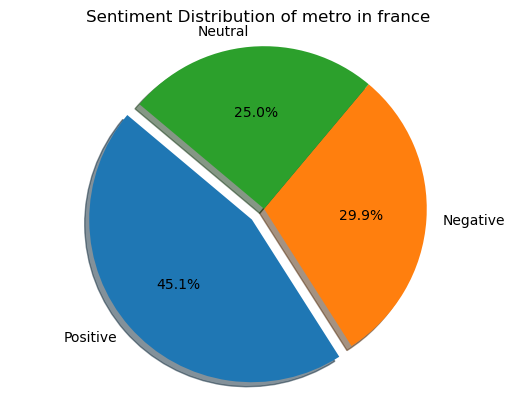

According to this analysis people in france have a Positive image of metro


,Post,Comment,Date,Sentiment_Value,Sentiment
0,Le METRO BOULOT DODO a t'il ses limites ?,"Welcome to the mid-30s crisis, more and more o...",2023-11-03 10:35:13,0.177288,Positive
1,Le METRO BOULOT DODO a t'il ses limites ?,"There are many, very many of us. Good luck.",2023-11-03 10:35:35,0.616667,Positive
2,Le METRO BOULOT DODO a t'il ses limites ?,You can also do something else.\nI have experi...,2023-11-03 11:11:34,0.005147,Positive
3,Le METRO BOULOT DODO a t'il ses limites ?,"Just curious, but what exactly are you doing i...",2023-11-03 14:57:13,0.050000,Positive
4,Le METRO BOULOT DODO a t'il ses limites ?,">I'm in finance.\n>\n>Today, I was hired in a ...",2023-11-03 18:08:04,-0.099107,Negative


In [12]:
sentiment_analysis_lan('france','metro',15,10)

### Sentiment prediction

## VADER Method

In [13]:
#!pip install scikit-learn
#!pip install spanish_sentiment_analysis
#!pip install keras tensorflow
#!pip install sentiment-analysis-spanish
#pip install marisa-trie
from sentiment_analysis_spanish import sentiment_analysis
#from classifier import SentimentClassifier

In [14]:
#sent_sp = sentiment_analysis.SentimentAnalysisSpanish()
#print(sent_sp.sentiment("me gusta la tombola es genial"))

In [15]:
#Create function to predict sentiment analysis

#Create Sentiment Analyzer object
#sent_analyzer = SentimentIntensityAnalyzer()

def format_output(output_dict):
  
  polarity = "Neutral"

  if(output_dict['compound'] >= 0.05):
    polarity = "Positive"

  elif(output_dict['compound'] <= -0.05):
    polarity = "Negative"

  return polarity

def predict_sentiment(text):
    
  sent_analyzer = SentimentIntensityAnalyzer()
  output_dict =  sent_analyzer.polarity_scores(text)
  return format_output(output_dict)

#Create function for sentiment analysis using VADER
def vader_analyzer(dataset,transport,location):
    
    #Read dataset
    df_sa=pd.read_csv(dataset) #we can use a dataset created in the last steps
    
    #Create Sentiment Analyzer object
    sent_analyzer = SentimentIntensityAnalyzer()

    #Select columns to analyze
    data=df_sa.loc[:,['Comment','Sentiment']]

    #Create Sentiment Analyzer object
    sent_analyzer = SentimentIntensityAnalyzer()

    #Check if the values are in english
    # Detect language and translate comments to english
    translator = googletrans.Translator()
    if detect(data['Comment'][0]) != 'en':
        data['Comment'] = data['Comment'].astype(str) #changing datatype to string 
        data['Comment'] = data['Comment'].apply(translator.translate, src='auto', dest='en').apply(getattr, args=('text',)) 

    
    #Apply sentiment prediction to a column and storage it in a new column

    data["vader_prediction"] = data["Comment"].apply(predict_sentiment)

    #Compute accuracy of the prediction compared to the actual values

    from sklearn.metrics import accuracy_score, classification_report

    accuracy = accuracy_score(data['Sentiment'], data['vader_prediction'])

    print("Accuracy: {}\n".format(accuracy))

    # Show the classification report
    print(classification_report(data['Sentiment'], data['vader_prediction']))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(data['Sentiment'], data['vader_prediction'])

    # Plot heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', linewidth=.5, cmap='Spectral', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix Sentiment Prediction for {transport} in {location}")
    plt.show()
    
    return data.head(3)

Accuracy: 0.5625

              precision    recall  f1-score   support

    Negative       0.35      0.41      0.38        17
     Neutral       0.77      0.53      0.63        32
    Positive       0.55      0.68      0.61        31

    accuracy                           0.56        80
   macro avg       0.56      0.54      0.54        80
weighted avg       0.60      0.56      0.57        80



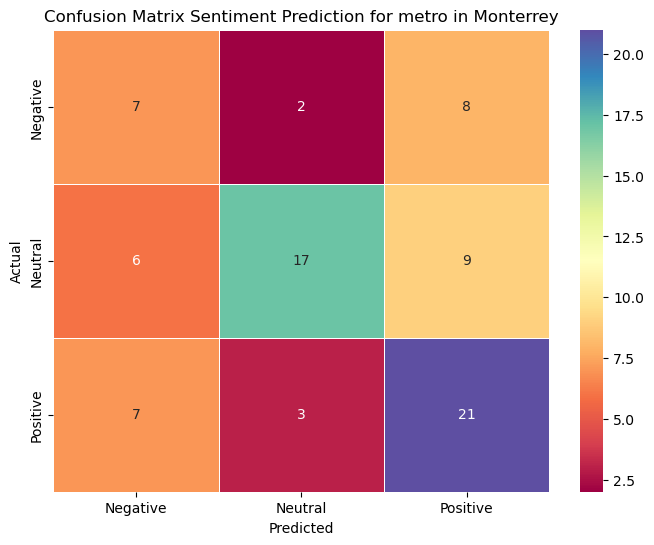

Accuracy: 0.625

              precision    recall  f1-score   support

    Negative       0.49      0.73      0.59        33
     Neutral       0.76      0.56      0.64        52
    Positive       0.65      0.63      0.64        51

    accuracy                           0.62       136
   macro avg       0.64      0.64      0.62       136
weighted avg       0.66      0.62      0.63       136



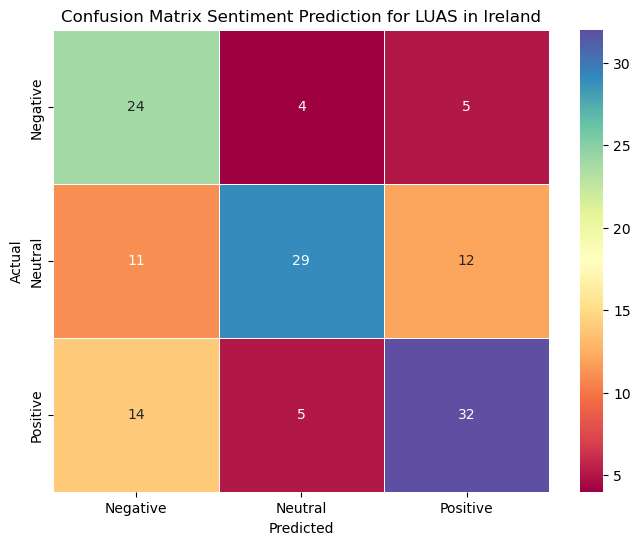

(                                             Comment Sentiment  \
 0                  What route are you talking about?   Neutral   
 1  I understand the green ones are with the metro...  Negative   
 2    Damn sick people...\n\nFortunately you are fine  Positive   
 
   vader_prediction  
 0          Neutral  
 1          Neutral  
 2         Negative  ,
                                              Comment Sentiment  \
 0  Can you think of any reason why this type of s...   Neutral   
 1                 How many times were you attacked ?  Positive   
 2  How often were you in court as a result of you...   Neutral   
 
   vader_prediction  
 0         Positive  
 1         Negative  
 2          Neutral  )

In [16]:
vader_analyzer('Monterrey_Transmetro_comments.csv','metro','Monterrey'), vader_analyzer('ireland_LUAS_comments.csv','LUAS','Ireland')

## Bag of words

In [20]:
def Bag_of_Words_lan(csv_file,transport):
    
    #Loading the Dataset
    df_bw = pd.read_csv(csv_file)

    # Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
    from sklearn.feature_extraction.text import CountVectorizer
    #nltk.download('stopwords')
    from nltk.corpus import stopwords
    from nltk.tokenize import RegexpTokenizer

    #Creating languages for the stopwords
    stop_words_sp = set(stopwords.words('spanish'))
    stop_words_en = set(stopwords.words('english'))

    translator = googletrans.Translator()
    if detect(df_bw['Comment'][0]) != 'en': 
    
        token = RegexpTokenizer(r'[a-zA-Z0-9]+')
        sw_sp_list = list(stop_words_sp)
        cv    = CountVectorizer(stop_words = sw_en_list,ngram_range = (1, 1),tokenizer = token.tokenize)
        text_counts = cv.fit_transform(df_bw['Comment'])
    
    elif detect(df_bw['Comment'][0]) != 'es':
        token = RegexpTokenizer(r'[a-zA-Z0-9]+')
        sw_sp_list = list(stop_words_sp)
        cv    = CountVectorizer(stop_words = sw_sp_list,ngram_range = (1, 1),tokenizer = token.tokenize)
        text_counts = cv.fit_transform(df_bw['Comment'])

    #print('********',text_counts,'*********')

    #Splitting the data into trainig and testing
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df_bw['Sentiment'], test_size=0.25, random_state=5)

    # Training the model
    from sklearn.naive_bayes import MultinomialNB
    MNB = MultinomialNB()
    MNB.fit(X_train, Y_train)

    # Caluclating the accuracy score of the model
    from sklearn import metrics
    predicted = MNB.predict(X_test)
    #print(Y_test,predicted)
    accuracy_score = metrics.accuracy_score(predicted, Y_test)

    print(f"Accuracy Score {transport}: ",accuracy_score, '\n')

    # Show the classification report
    from sklearn.metrics import accuracy_score, classification_report
    print(classification_report(Y_test, predicted))

    #Cross-validation 
    from sklearn.model_selection import cross_val_score
    cv_scores = cross_val_score(MNB, text_counts, df_bw['Sentiment'], cv=5)
    print(f"Cross-Validation Scores {transport}: {cv_scores}")
    print(f"Mean Cross-Validation Score {transport}: {cv_scores.mean()} \n")
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(Y_test, predicted)

    # Plot heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', linewidth=.5, xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix Sentiment Prediction for {transport}")
    plt.show()

Accuracy Score transmetro:  0.45 

              precision    recall  f1-score   support

    Negative       0.29      0.40      0.33         5
     Neutral       1.00      0.38      0.55         8
    Positive       0.40      0.57      0.47         7

    accuracy                           0.45        20
   macro avg       0.56      0.45      0.45        20
weighted avg       0.61      0.45      0.47        20

Cross-Validation Scores transmetro: [0.3125 0.25   0.5625 0.5    0.4375]
Mean Cross-Validation Score transmetro: 0.4125 



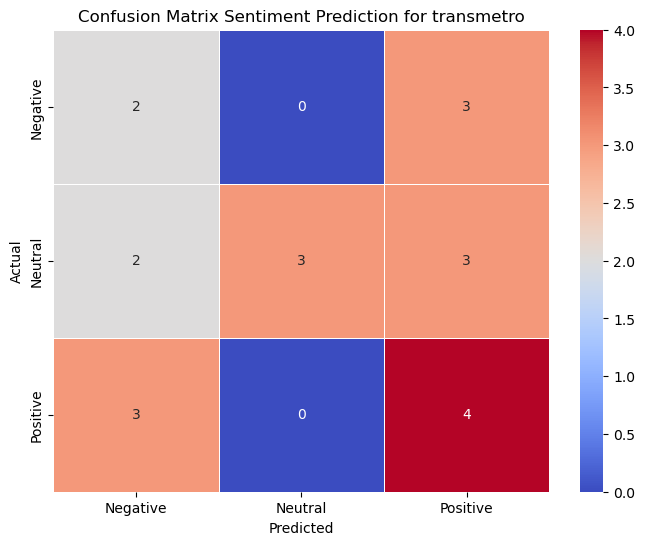

Accuracy Score LUAS:  0.5294117647058824 

              precision    recall  f1-score   support

    Negative       0.80      0.33      0.47        12
     Neutral       0.78      0.58      0.67        12
    Positive       0.35      0.70      0.47        10

    accuracy                           0.53        34
   macro avg       0.64      0.54      0.53        34
weighted avg       0.66      0.53      0.54        34

Cross-Validation Scores LUAS: [0.5        0.40740741 0.37037037 0.51851852 0.40740741]
Mean Cross-Validation Score LUAS: 0.44074074074074077 



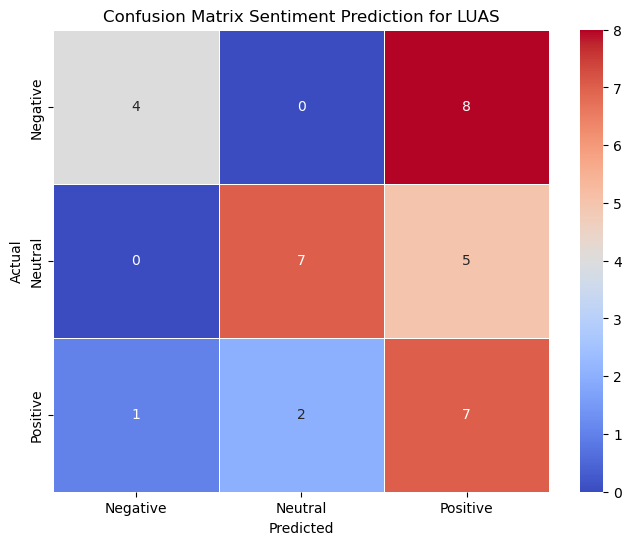

(None, None)

In [21]:
Bag_of_Words_lan('Monterrey_transmetro_comments.csv','transmetro'), Bag_of_Words_lan('ireland_LUAS_comments.csv','LUAS')